An advanced CNN structure can be used to classify a dogs breed based on its picture. However, training an entire advanced CNN structures take time. One approach to save time is to use a pretrained model whose training set includes sufficient dog data. For this I chose `ResNet50` with weights trained on `ImageNet1000` dataset. I replaced the top two layers of `ResNet50` with a Global Average Pooling layer and a softmax layer with `120` nodes. These layers are then fine tuned to detect dog breeds.

## 

### Imports and GPU setting

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import os
import cv2
import GPUtil
import matplotlib.pyplot as plt                        
%matplotlib inline  

# In a multi GPU server, chose which to use:
NUMBER_OF_GPUS_TO_USE = 1
Availability=GPUtil.getAvailability(GPUtil.getGPUs())
all_gpus = np.arange(3)
available_gpu_indexes = [x for x in all_gpus if Availability[x]]
# Set CUDA_DEVICE_ORDER so the IDs assigned by CUDA match those from nvidia-smi
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# Set CUDA_VISIBLE_DEVICES to mask out all other GPUs than the first NUMBER_OF_GPUS_TO_USE available device id
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(np.array(available_gpu_indexes[:NUMBER_OF_GPUS_TO_USE]).astype(str))

import tensorflow as tf
config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

import keras
from keras.backend.tensorflow_backend import set_session

set_session(tf.Session(config=config))

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.models import Sequential
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.core import Dense

from keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from glob import glob

from keras.engine.input_layer import Input
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint

In [5]:
import pandas as pd

In [5]:
import string, random
def id_generator(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

In [26]:
def path_to_tensor(img_path, expand=True):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    if expand:
        return np.expand_dims(x, axis=0)
    else:
        return x

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Confirm the image is actually a dog

In [5]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [7]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Create dataset

In [7]:
img_path = "/notebooks/Practice/imgnet-dogbreed/Images/"

In [8]:
data = load_files(img_path)

In [9]:
_ = data.pop('target_names')
_ = data.pop('DESCR')
_ = data.pop('data')

In [10]:
data_frame = pd.DataFrame.from_dict(data)

In [11]:
train_files = []
test_files = []
train_targets = []
test_targets = []
for dog_breed in data_frame.target.value_counts().index:
    # take 10% of the images for each class as test set to ensure same “distribution” of train and test set
    train_files_tmp, test_files_tmp, train_targets_tmp, test_targets_tmp = train_test_split(data_frame[data_frame.target == dog_breed].filenames.values, data_frame[data_frame.target == dog_breed].target.values, test_size=0.1)
    train_files.append(train_files_tmp)
    test_files.append(test_files_tmp)
    train_targets.append(train_targets_tmp)
    test_targets.append(test_targets_tmp)
train_files = np.concatenate(train_files[:])
test_files = np.concatenate(test_files[:])
train_targets = np.concatenate(train_targets[:])
test_targets = np.concatenate(test_targets[:])
train_targets = np_utils.to_categorical(np.array(train_targets), 120)
test_targets = np_utils.to_categorical(np.array(test_targets), 120)

In [12]:
# print statistics about the dataset
print('There are %d total dog categories.' % len(data_frame.target.value_counts()))
print('There are %s total dog images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d test dog images.'% len(test_files))

There are 120 total dog categories.
There are 20580 total dog images.

There are 18470 training dog images.
There are 2110 test dog images.


Use data augmentation to increase performance

In [13]:
def random_crop(image):
    """Crops a random region of width x height from image.
    Returns an image"""
    ratio = 0.8
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    crop_origin_x = np.random.randint(0, image.shape[0] - width)
    crop_origin_y = np.random.randint(0, image.shape[1] - height)
    cropped_image = image[crop_origin_y:crop_origin_y+height,crop_origin_x:crop_origin_x+width,:]
    cropped_image = cv2.resize(cropped_image,(image.shape[0],image.shape[1]))
    return cropped_image

In [14]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(preprocessing_function=random_crop,
                                   rotation_range=45,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# create and configure augmented image generator
datagen_test = ImageDataGenerator() 

In [15]:
# Preprocess images for ResNet50
processed_train_files = preprocess_input(paths_to_tensor(train_files))
processed_test_files = preprocess_input(paths_to_tensor(test_files))

In [10]:
train_targets = np.load('ResNet50/train_targets.npy')
test_targets = np.load('ResNet50/test_targets.npy')

train_files = np.load('ResNet50/train_files.npy')
test_files = np.load('ResNet50/test_files.npy')

processed_train_files = np.load('ResNet50/processed_train_files.npy')
processed_test_files = np.load('ResNet50/processed_test_files.npy')

In [16]:
# fit augmented image generator on data
datagen_train.fit(processed_train_files)
datagen_test.fit(processed_test_files)

In [17]:
input_img = Input(shape=(224, 224, 3))
# The ResNet50 model that is used to obtain bottleneck features
model_resnet = ResNet50(weights='imagenet', include_top=False,
    input_shape=(224, 224, 3),
    input_tensor=input_img)

In [18]:
train_flow = datagen_train.flow(processed_train_files, train_targets, shuffle=True, batch_size=1000)
test_flow = datagen_test.flow(processed_test_files, test_targets, shuffle=False, batch_size=len(test_files))

### Final model with transfer learning

In [19]:
### Define architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 2048)))
Resnet50_model.add(Dense(120, activation='softmax'))

In [20]:
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 245,880
Trainable params: 245,880
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the model and set checkpoints
Resnet50_model.compile(optimizer=keras.optimizers.Nadam(),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[keras.metrics.categorical_accuracy])

In [21]:
temp_id = id_generator()
os.makedirs('ResNet50/'+temp_id)
checkpointer_resnet = ModelCheckpoint(filepath='ResNet50/'+temp_id+'/weights.best.ResNet50.hdf5', 
                               verbose=0, save_best_only=True)

tb = keras.callbacks.TensorBoard(log_dir='./logs/'+temp_id, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

In [22]:
### Train the model.
for x,y in train_flow:    
    history = Resnet50_model.fit(model_resnet.predict(x), y, epochs=5, callbacks=[checkpointer_resnet, tb], validation_split=.1, verbose=0)
    if history.history['val_categorical_accuracy'][0] > .9:
        break    

KeyboardInterrupt: 

In [23]:
%%time 

test_features = model_resnet.predict(processed_test_files)

### Calculate classification accuracy on the test dataset.
predictions = np.argmax(Resnet50_model.predict(test_features), axis=1)
actual = np.argmax(test_targets, axis=1)
# Report test accuracy
test_accuracy = 100*np.sum(predictions==actual)/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 73.5071%
CPU times: user 8.19 s, sys: 3.18 s, total: 11.4 s
Wall time: 10.6 s


In [55]:
np.save('ResNet50/train_targets', train_targets)
np.save('ResNet50/test_targets', test_targets)

In [24]:
np.save('ResNet50/train_files',train_files)
np.save('ResNet50/test_files',test_files)

np.save('ResNet50/processed_train_files', processed_train_files)
np.save('ResNet50/processed_test_files', processed_test_files)

### To do

- Optimize memory usage

## Application

In [6]:
def path_to_tensor(img_path, expand=True):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [7]:
input_img = Input(shape=(224, 224, 3))
# The ResNet50 model that is used to obtain bottleneck features
model_resnet = ResNet50(weights='imagenet', include_top=False,
    input_shape=(224, 224, 3),
    input_tensor=input_img)

In [8]:
### Define architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=(7, 7, 2048)))
Resnet50_model.add(Dense(120, activation='softmax'))

In [9]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('ResNet50/H6M9EM/weights.best.ResNet50.hdf5')

In [18]:
def Resnet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(Resnet50_model.predict(model_resnet.predict(img)))

In [12]:
img_path = "/notebooks/Practice/imgnet-dogbreed/Images/"
data = load_files(img_path)

In [16]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [17]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

This dog belongs to Airedale breed.


(-0.5, 223.5, 223.5, -0.5)

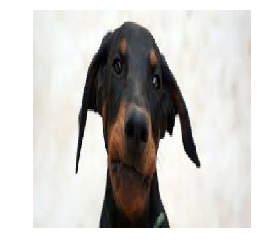

In [49]:
path_ = 'AIND2-dog-project/my_images/doberman_floppy_ears.jpg'
if dog_detector(path_):
    print('This dog belongs to {} breed.'.format(data['target_names'][Resnet50_predict_labels(path_)].split('-')[1]))
    _=plt.imshow(np.squeeze(path_to_tensor(path_)/255., axis=0));
    plt.axis('off')
else:
    print("This does not look like a dog.")